# Loading Data and EDA

In [1]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
import pylab 
from ols_bootstrap.wild import WildBootstrap
import statsmodels.api as sm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from copy import deepcopy as dcp 
sns.set_theme(style="darkgrid")


rng=np.random.default_rng(1001) #seed is 1001, because there is a book called One Thousand and One Nights and 1001 = 7*11*13
seed_lst = rng.integers(low=1, high=100000, size = 1000, endpoint=True)

In [2]:
balance2014 = pd.read_csv('./2014.csv')
commerce2014 = balance2014[balance2014['teaor08_1d'] == 'G'].reset_index()
commerce2014['is_exporter'] = np.where(commerce2014['export'] > 0.0, 1, 0)

/home/phamv/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(commerce2014[commerce2014['export'] > 0].shape[0])
print((commerce2014['is_exporter'] == 1).sum())
commerce2014['is_exporter'].value_counts()

11826
11826


0    87817
1    11826
Name: is_exporter, dtype: int64

In [4]:
temp_df = commerce2014[(commerce2014['emp'] > 0.0) & (commerce2014['wbill'] > 0.0)] # commerce2014[commerce2014['emp'] > 0.0 ]
temp_df['log_avg_wage'] = np.log((temp_df['wbill'] / temp_df['emp']) + 1) 
temp_df['log_emp'] = np.log(temp_df['emp'])
temp_df['const'] = np.ones(temp_df.shape[0])

/tmp/ipykernel_4991/2956559449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['log_avg_wage'] = np.log((temp_df['wbill'] / temp_df['emp']) + 1)
/tmp/ipykernel_4991/2956559449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['log_emp'] = np.log(temp_df['emp'])
/tmp/ipykernel_4991/2956559449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [5]:
df = temp_df[['log_avg_wage', 'const', 'log_emp', 'is_exporter']]

In [31]:
df['is_exporter'].value_counts()

0    50249
1    10743
Name: is_exporter, dtype: int64

In [6]:
Y = pd.DataFrame(df.iloc[:, 0])
X = pd.DataFrame(df.iloc[:, 1:])

In [7]:
np.linalg.lstsq(X, Y, rcond=None)[0]

array([[6.78326481],
       [0.21047924],
       [0.32264759]])

In [8]:
statsmodels_model = sm.OLS(Y, X)
statsmodels_result = statsmodels_model.fit(cov_type="HC3")
print(statsmodels_result.summary())

                            OLS Regression Results                            
Dep. Variable:           log_avg_wage   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     4083.
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:00:12   Log-Likelihood:                -67185.
No. Observations:               60992   AIC:                         1.344e+05
Df Residuals:                   60989   BIC:                         1.344e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.7833      0.005   1336.424      

In [9]:
df

,log_avg_wage,const,log_emp,is_exporter
1,8.721092,1.0,3.135494,1
2,8.492360,1.0,2.397895,0
3,8.153494,1.0,0.693147,0
6,6.021023,1.0,0.000000,0
7,7.747705,1.0,1.386294,0
...,...,...,...,...
99637,7.105786,1.0,0.000000,0
99639,7.000334,1.0,1.098612,0
99640,7.149524,1.0,2.079442,0
99641,7.090910,1.0,0.693147,0


<AxesSubplot:xlabel='log_avg_wage', ylabel='Count'>

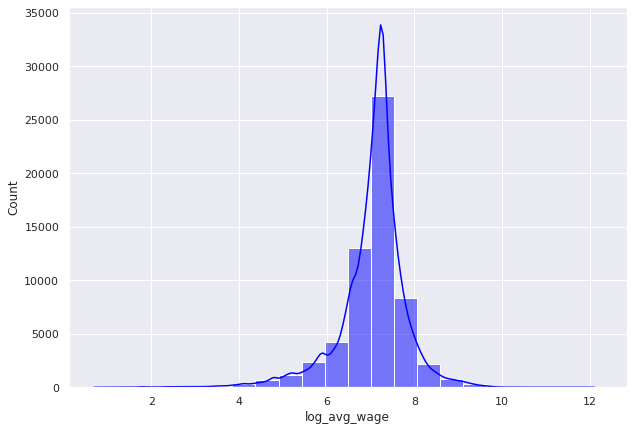

In [10]:
plt.figure(figsize=(10,7))
sns.histplot(data=df['log_avg_wage'], color='blue', binwidth = 0.526, kde = True)

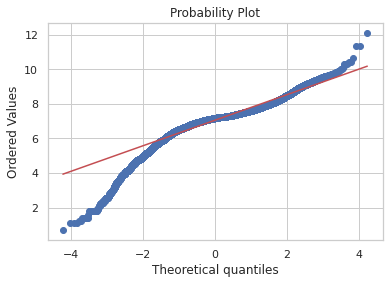

In [39]:
import scipy.stats as stats
import pylab 

stats.probplot(df['log_avg_wage'].to_numpy(), dist='norm', plot=pylab)
pylab.show()


In [45]:
from scipy.stats import normaltest #D’Agostino’s K-squared test

stat, p = normaltest(df['log_avg_wage'].to_numpy())
if p > 0.05: 
    print('Probably Gaussian')
else: 
    print('Probabily not Gaussian')

Probabily not Gaussian


In [44]:
from scipy.stats import jarque_bera #Jarque-Bera test for Normality 

stat, p = jarque_bera(df['log_avg_wage'].to_numpy())
if p > 0.05: 
    print('Probably Gaussian')
else: 
    print('Probabily not Gaussian')

Probabily not Gaussian


In [47]:
from scipy.stats import kstest

stat, p = kstest(df['log_avg_wage'].to_numpy(), 'norm')
if p > 0.05: 
    print('Probably Gaussian')
else: 
    print('Probabily not Gaussian')

Probabily not Gaussian


<AxesSubplot:xlabel='log_emp', ylabel='Count'>

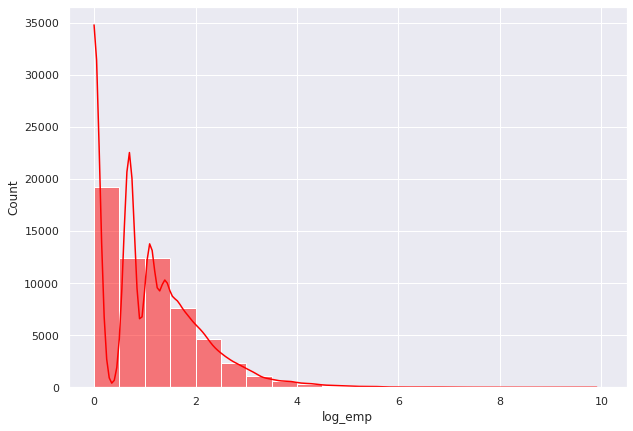

In [11]:
plt.figure(figsize=(10,7))
sns.histplot(data=df['log_emp'], color='red', binwidth = 0.5, kde = True)

<AxesSubplot:>

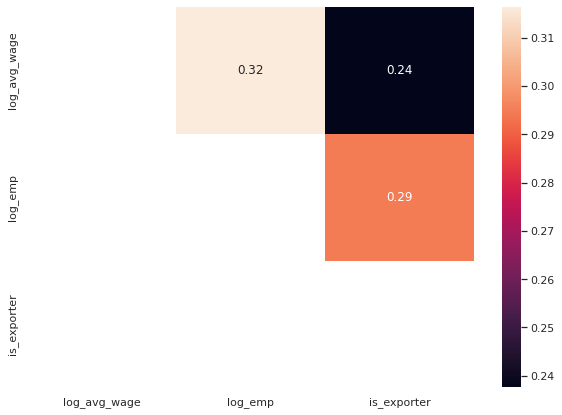

In [12]:
plt.figure(figsize=(10,7))
sns.set(style="whitegrid")
corr= df[['log_avg_wage', 'log_emp', 'is_exporter']].corr()
mtx_heatmap = np.tril(corr)
sns.heatmap(corr, annot=True, mask=mtx_heatmap)

In [13]:
df.describe()

,log_avg_wage,const,log_emp,is_exporter
count,60992.000000,60992.0,60992.000000,60992.000000
mean,7.057395,1.0,1.032406,0.176138
std,0.777407,0.0,0.996697,0.380941
min,0.693147,1.0,0.000000,0.000000
25%,6.796824,1.0,0.000000,0.000000
50%,7.176255,1.0,0.693147,0.000000
75%,7.427144,1.0,1.609438,0.000000
max,12.104361,1.0,9.909569,1.000000


# Bootstrap Confidence Interval (CI) Simulations

In [14]:
def conf_inf_computation(df, num, lst_seed): 
    conf_inf_bca=np.zeros((len(lst_seed), 3))
    conf_inf_bc=np.zeros((len(lst_seed), 3))
    conf_inf_perc=np.zeros((len(lst_seed), 3))
    conf_inf_basic=np.zeros((len(lst_seed), 3))

    orig_param = np.linalg.lstsq(X, Y, rcond=None)[0]
    tol = 10e-8
    for i, val in enumerate(lst_seed): 
        df_sample = df.sample(n=num, replace=False, random_state=val)
        Y_data = pd.DataFrame(df_sample.iloc[:, 0])
        X_data = pd.DataFrame(df_sample.iloc[:, 1:])

        wb = WildBootstrap(Y_data, X_data, reps = 10000, ci_type='bca', from_distro = "rademacher", se_type='hc3', scale_resid_bool = True, seed = val, fit_intercept=False)
        wb.fit()

        ci_bca = wb.bs_ci
        ci_bc = wb.get_bca_ci(which_ci =['bc']).to_numpy()
        ci_perc = wb.get_bca_ci(which_ci =['percentile']).to_numpy()
        ci_basic = wb.get_bca_ci(which_ci =['basic']).to_numpy()

        conf_inf_bca[i, :] = (orig_param[:, 0] > ci_bca[:, 0] - tol) & (orig_param[:, 0] < ci_bca[:, 1] + tol)
        conf_inf_bc[i, :] = (orig_param[:, 0] > ci_bc[:, 0] - tol) & (orig_param[:, 0] < ci_bc[:, 1] + tol)
        conf_inf_perc[i, :] = (orig_param[:, 0] > ci_perc[:, 0] - tol) & (orig_param[:, 0] < ci_perc[:, 1] + tol)
        conf_inf_basic[i, :] = (orig_param[:, 0] > ci_basic[:, 0] - tol) & (orig_param[:, 0] < ci_basic[:, 1] + tol)

    return conf_inf_bca, conf_inf_bc, conf_inf_perc, conf_inf_basic

In [15]:
conf_inf_bca_100, conf_inf_bc_100, conf_inf_perc_100, conf_inf_basic_100 = conf_inf_computation(df, num=100, lst_seed=seed_lst)
conf_inf_bca_600, conf_inf_bc_600, conf_inf_perc_600, conf_inf_basic_600 = conf_inf_computation(df, num=600, lst_seed=seed_lst)
conf_inf_bca_1100, conf_inf_bc_1100, conf_inf_perc_1100, conf_inf_basic_1100 = conf_inf_computation(df, num=1100, lst_seed=seed_lst)


In [16]:
intervals = {'bca_100': conf_inf_bca_100, 
             'bc_100': conf_inf_bc_100, 
             'perc_100': conf_inf_perc_100, 
             'basic_100': conf_inf_basic_100,
             'bca_600': conf_inf_bca_600, 
             'bc_600': conf_inf_bc_600, 
             'perc_600': conf_inf_perc_600, 
             'basic_600': conf_inf_basic_600,
             'bca_1100': conf_inf_bca_1100, 
             'bc_1100': conf_inf_bc_1100, 
             'perc_1100': conf_inf_perc_1100, 
             'basic_1100': conf_inf_basic_1100,}

var_translate = {'log_emp':1, 'is_exporter':2}

log_emp_arr = np.zeros((12,2))
is_exp_arr = np.zeros_like(log_emp_arr)

for i, name in enumerate(intervals): 
    log_emp_arr[i, :] = np.unique(intervals[name][:, var_translate['log_emp']], return_counts=True)[1]
    is_exp_arr[i, :] = np.unique(intervals[name][:, var_translate['is_exporter']], return_counts=True)[1]

df_log_emp_ci_test = pd.DataFrame(data = log_emp_arr.T, columns = intervals.keys())
df_is_exp_arr_ci_test = pd.DataFrame(data = is_exp_arr.T, columns = intervals.keys())

In [17]:
df_log_emp_ci_test

,bca_100,bc_100,perc_100,basic_100,bca_600,bc_600,perc_600,basic_600,bca_1100,bc_1100,perc_1100,basic_1100
0,60.0,59.0,58.0,58.0,46.0,44.0,44.0,45.0,56.0,55.0,55.0,56.0
1,940.0,941.0,942.0,942.0,954.0,956.0,956.0,955.0,944.0,945.0,945.0,944.0


In [18]:
df_is_exp_arr_ci_test

,bca_100,bc_100,perc_100,basic_100,bca_600,bc_600,perc_600,basic_600,bca_1100,bc_1100,perc_1100,basic_1100
0,67.0,59.0,60.0,57.0,58.0,51.0,51.0,50.0,46.0,42.0,46.0,47.0
1,933.0,941.0,940.0,943.0,942.0,949.0,949.0,950.0,954.0,958.0,954.0,953.0


# Bootstrap Distribution Related Plotting

In [19]:
sample_size_lst = [50, 100, 200, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
reps_lst = [10, 50, 100, 200, 500, 1000, 10000]

In [20]:
def create_empty_df(column_names):
    df = pd.DataFrame(columns = column_names)
    
    return df 

In [21]:
sample_dict = dict()
bootstrap_sample_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
estimator_lst =  ['log_emp', 'is_exporter']


for ss in sample_size_lst: 
    sample_dict[ss] = None

for ss in sample_size_lst: 
    for reps in reps_lst:
        for estim in estimator_lst:
            bootstrap_sample_dict[ss][reps][estim] = None


In [22]:
#### With reps and confidence interval 
encompassing_df = None
var_translate = {'log_emp':1, 'is_exporter':2}
seed_val = rng.choice(seed_lst, 1)

for ss in sample_size_lst:
 
    sample_from_pop = df.sample(n=ss, replace=False, random_state=seed_val)
    sample_dict[ss] = sample_from_pop

    Y_from_pop = pd.DataFrame(sample_from_pop.iloc[:, 0])
    X_from_pop = pd.DataFrame(sample_from_pop.iloc[:, 1:])
    ols_results = np.linalg.lstsq(X_from_pop, Y_from_pop, rcond=None)[0].flatten()

    ols_log_emp = ols_results[1]
    ols_is_exporter = ols_results[2]

    for reps in reps_lst: 
        resample_df = sample_from_pop.sample(n=ss, replace=True, random_state=seed_val)
        Y_resampled = pd.DataFrame(sample_from_pop.iloc[:, 0])
        X_resampled = pd.DataFrame(sample_from_pop.iloc[:, 1:])
        wb_bca_webb6 = WildBootstrap(Y_resampled, X_resampled, reps = reps, ci_type='bca', from_distro = "webb6", seed = seed_val, fit_intercept=False)
        wb_bca_webb6.fit()

        ### Store in the dict
        bootstrap_sample_dict[ss][reps]['log_emp'] = wb_bca_webb6.bs_params[1, :]
        bootstrap_sample_dict[ss][reps]['is_exporter'] = wb_bca_webb6.bs_params[2, :]

        bs_df = create_empty_df(['Sample_Size', 'Bs_Resample', 'Sample_Facts', 'Statistics/Estimator', 'Mean', '0.025', '0.975'])

        bs_df['Sample_Size'] = [ss for _ in range(2)]
        bs_df['Bs_Resample'] = [reps for _ in range(2)]
        bs_df['Sample_Facts'] = [ols_log_emp, ols_is_exporter]

        bs_df['Statistics/Estimator'] = ['log_emp', 'is_exporter']

        bs_df['Mean'] = [np.mean(wb_bca_webb6.bs_params[1, :]), np.mean(wb_bca_webb6.bs_params[2, :])]

        bs_df['0.025'] = [wb_bca_webb6.bs_ci[1,0], wb_bca_webb6.bs_ci[2,0]]

        bs_df['0.975'] = [wb_bca_webb6.bs_ci[1,1], wb_bca_webb6.bs_ci[2,1]]
        
        encompassing_df = pd.concat([encompassing_df, bs_df])   


encompassing_df = encompassing_df.reset_index(drop = True).round(4)

In [23]:
encompassing_df

,Sample_Size,Bs_Resample,Sample_Facts,Statistics/Estimator,Mean,0.025,0.975
0,50,10,0.0907,log_emp,0.0970,-0.0220,0.1490
1,50,10,0.0853,is_exporter,0.1308,-0.0075,0.1918
2,50,50,0.0907,log_emp,0.0933,-0.0213,0.1992
3,50,50,0.0853,is_exporter,0.1090,-0.0311,0.2795
4,50,100,0.0907,log_emp,0.0916,-0.0273,0.2101
...,...,...,...,...,...,...,...
149,10000,500,0.3207,is_exporter,0.3208,0.2855,0.3543
150,10000,1000,0.2053,log_emp,0.2052,0.1917,0.2205
151,10000,1000,0.3207,is_exporter,0.3210,0.2858,0.3565
152,10000,10000,0.2053,log_emp,0.2051,0.1912,0.2200


### Changes in Bootstrap Distributions

In [24]:
sample_lst = [50, 200, 1000, 10000]
bs_lst = [10,100,1000,10000]

estim_explainer = {'log_emp': 'Log employment',
                   'is_exporter': 'exporter', 
                  }

def kdeplot_estimator(figsize, estimator, estim_explainer, bootstrap_sample_dict, pop_value, sample_size_lst = sample_lst, bs_reps_lst = bs_lst, color=['red', 'blue', 'blue', 'green'], isFill='False'):
    line_position_lower = []
    line_position_higher = []
    line_position_mean = [] 

    row_num = len(sample_size_lst)
    col_num = len(bs_reps_lst)
    fig, axes = plt.subplots(nrows = row_num, ncols=col_num, figsize=figsize, constrained_layout=True)
    for i, ss in enumerate(sample_size_lst):
        for j, bs in enumerate(bs_reps_lst):
            sns.kdeplot(data=bootstrap_sample_dict[ss][bs][estimator], color=color[0], fill = isFill, ax=axes[i][j], legend = False).set(title=f'Bootstrap Sampling Distro of the {estim_explainer[estimator]} with SS {ss} and BS {bs} (pop = {pop_value})')
            line_position_lower.append(np.percentile(bootstrap_sample_dict[ss][bs][estimator],2.5))
            line_position_higher.append(np.percentile(bootstrap_sample_dict[ss][bs][estimator],97.5))
            line_position_mean.append(np.mean(bootstrap_sample_dict[ss][bs][estimator]))


    for ax, pos_lower, pos_higher, pos_mean in zip(fig.axes, line_position_lower, line_position_higher, line_position_mean): 
        ax.axvline(pos_lower, color = color[1],linewidth=2)
        ax.text(pos_lower, 0, f'2.5th pct = {pos_lower:.3f}', color = 'black', rotation=270, transform=ax.get_xaxis_text1_transform(-30)[0])
        ax.axvline(pos_higher, color = color[2],linewidth=2)
        ax.text(pos_higher, 0, f'97.5th pct = {pos_higher:.3f}', color = 'black', rotation=270, transform=ax.get_xaxis_text1_transform(-30)[0])
        ax.axvline(pos_mean, color = color[3],linewidth=2)
        ax.text(pos_mean, 0, f'Mean = {pos_mean:.3f}', color = 'black', rotation=270, transform=ax.get_xaxis_text1_transform(-30)[0])

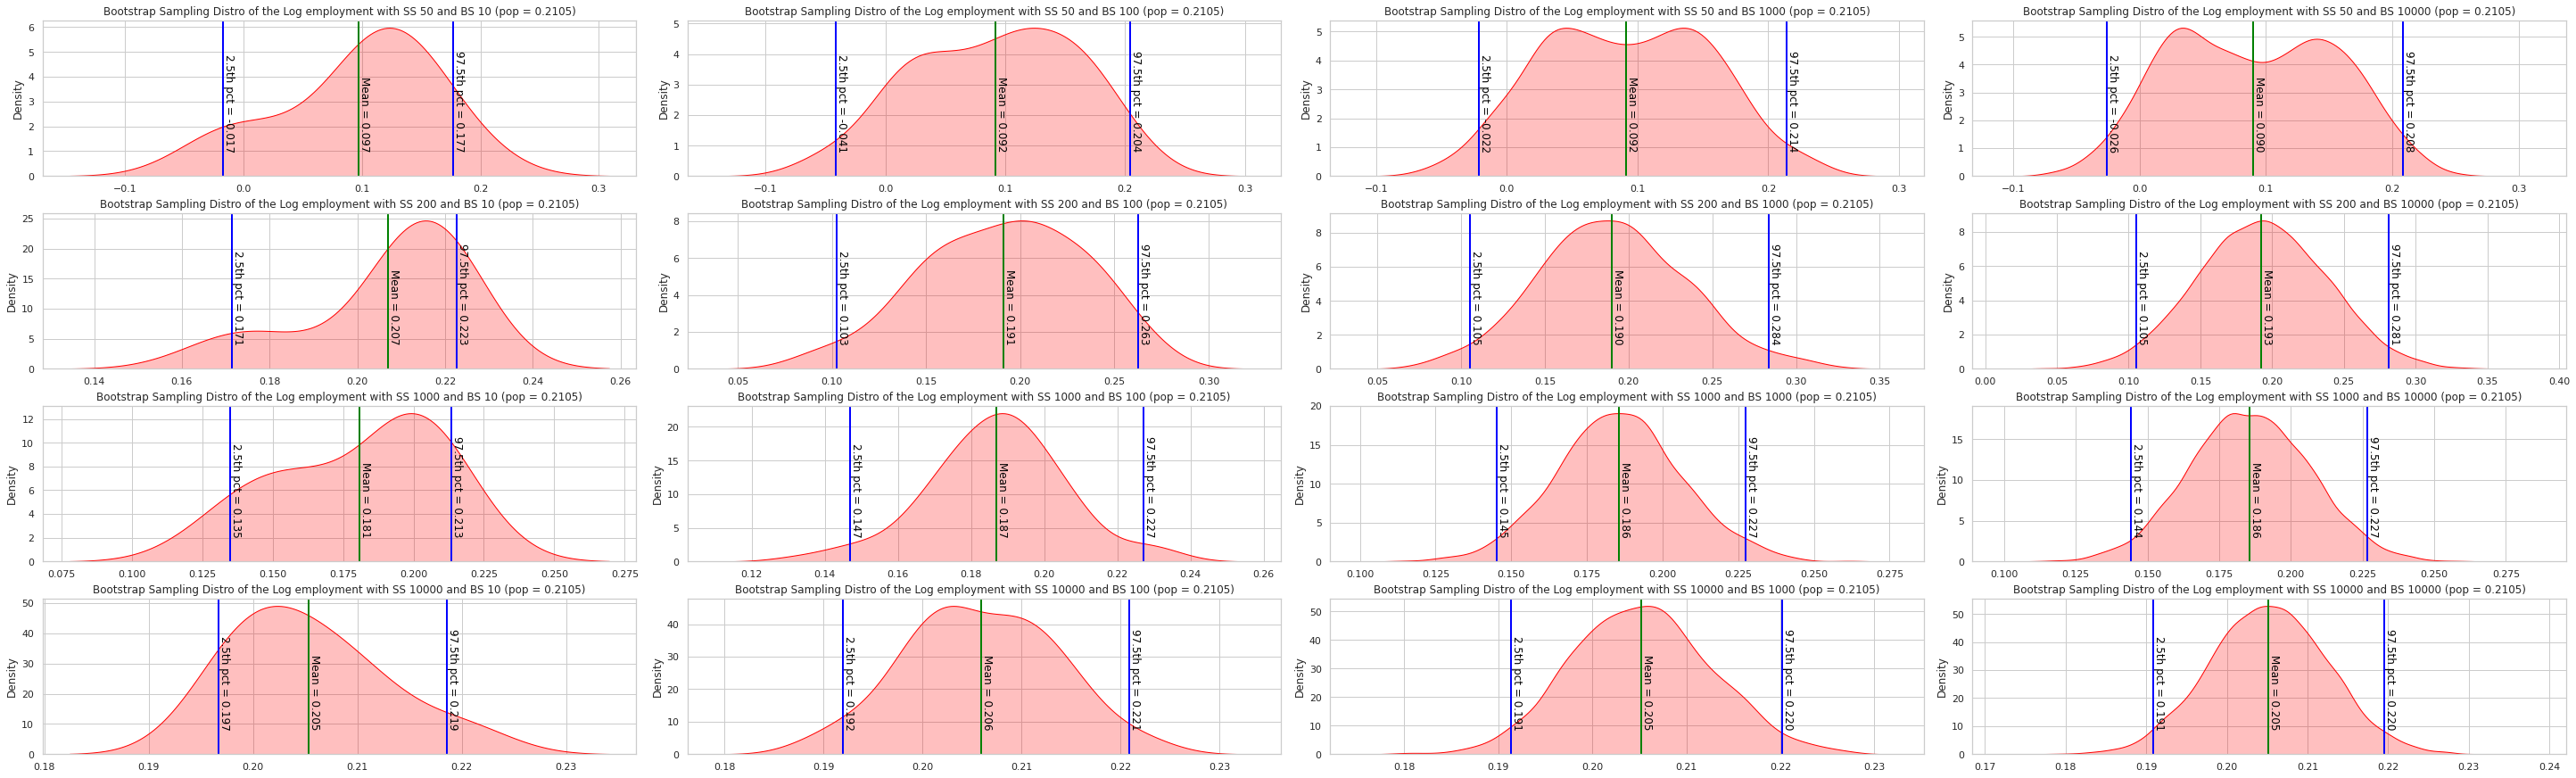

In [25]:
kdeplot_estimator((40,12), 'log_emp', estim_explainer, bootstrap_sample_dict, pop_value = 0.2105, isFill='True')

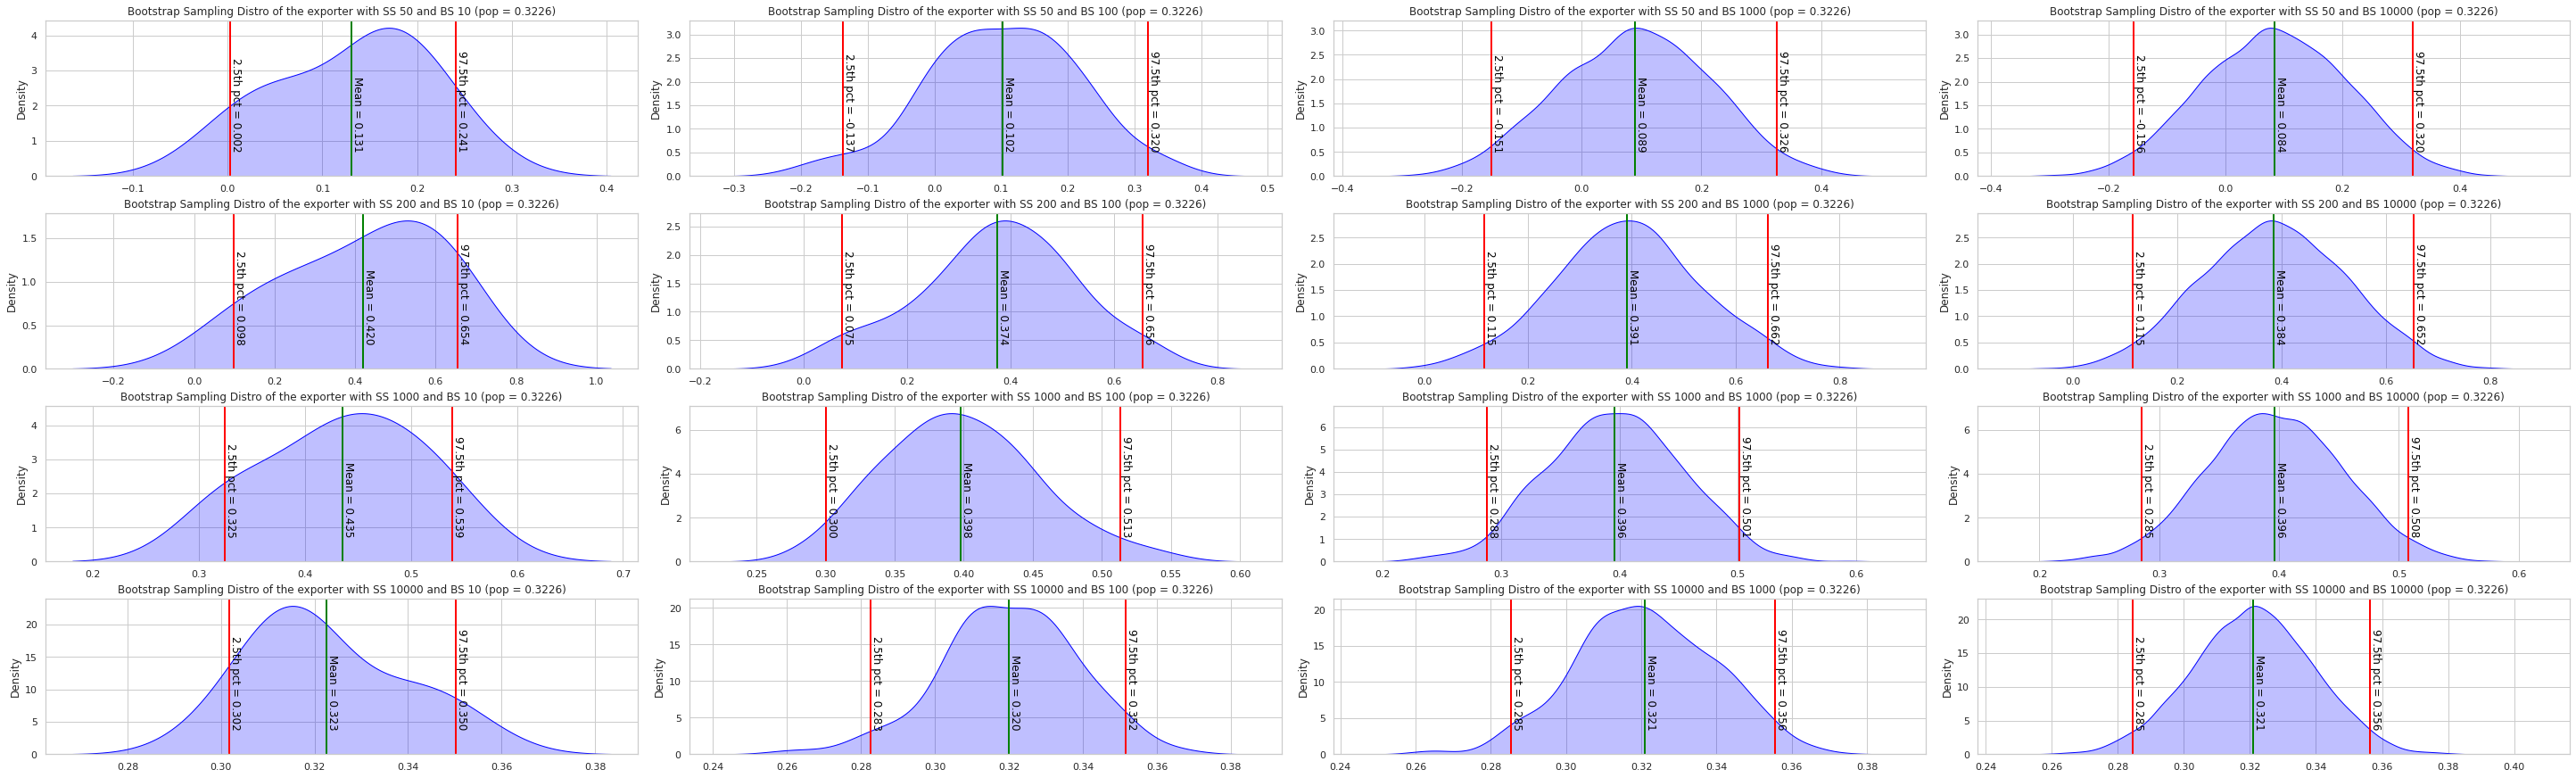

In [51]:
kdeplot_estimator((40,12), 'is_exporter', estim_explainer, bootstrap_sample_dict, pop_value = 0.3226, color = ['blue', 'red', 'red', 'green'], isFill='True')

### Movement of CI and Mean values as Increasing Sample Sizes and Bootstrap Replication Numbers

In [27]:
log_emp_bs_stats_df = encompassing_df[encompassing_df['Statistics/Estimator'] == 'log_emp']
is_exporter_bs_stats_df = encompassing_df[encompassing_df['Statistics/Estimator'] == 'is_exporter']

def CI_mean_vals_into_a_col(df, bs_resample):
    concat_df = None
    for bs in bs_resample: 
        df_temp = df[df['Bs_Resample'] == bs][['Sample_Size', '0.025', 'Mean', '0.975']]
        dfm = df_temp.melt('Sample_Size', var_name = 'cols', value_name = 'values')
        dfm['Bs_Resample'] = bs

        concat_df = pd.concat([concat_df, dfm], ignore_index=True)

    return concat_df

df_ci_mean_log_emp = CI_mean_vals_into_a_col(log_emp_bs_stats_df, [10, 50, 100, 200, 500, 1000, 10000])
df_ci_mean_is_exporter = CI_mean_vals_into_a_col(is_exporter_bs_stats_df, [10, 50, 100, 200, 500, 1000, 10000])


In [28]:
def plot_CI_ols(df, pop_val, title, bs_resample = [10, 50, 100, 1000]):

    for i, bs in enumerate(bs_resample):
        g = sns.relplot(x="Sample_Size", y="values", hue = 'cols',  
        palette = ['green','blue','green'],  kind="line",  facet_kws={'legend_out': False}, 
        data=df[df['Bs_Resample'] == bs], markers=True, height = 5, aspect = 2.5).set(title = f'Mean and 95% CI values of the {title} when the # of bootstrapping resampling is {bs}')

        plt.axhline(pop_val,color = 'red',linewidth=2, ls = '--')

        leg = g.axes.flat[0].get_legend()
        new_title = 'Measures'
        leg.set_title(new_title)
        new_labels = ['0.025', 'Mean', '0.975']
        for t, l in zip(leg.texts, new_labels):
            t.set_text(l)

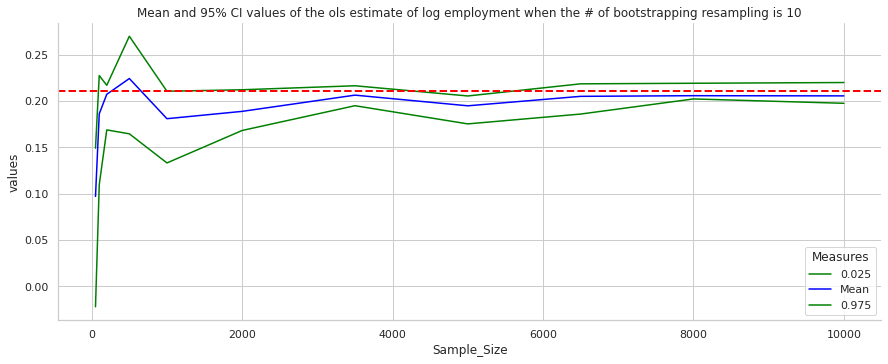

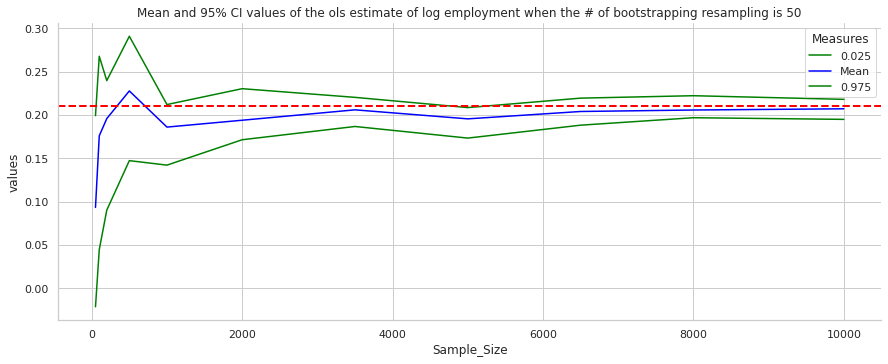

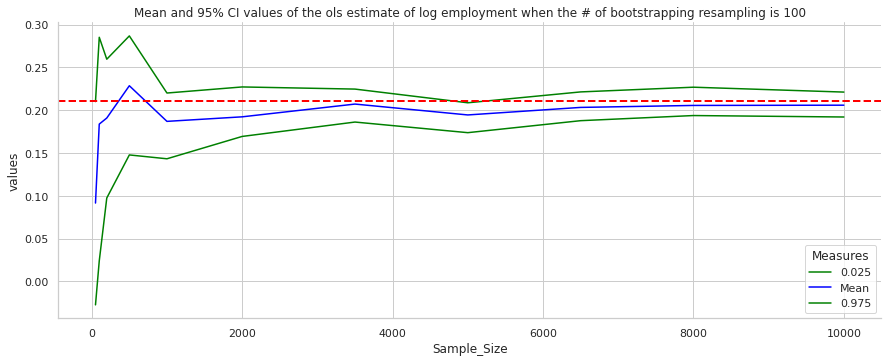

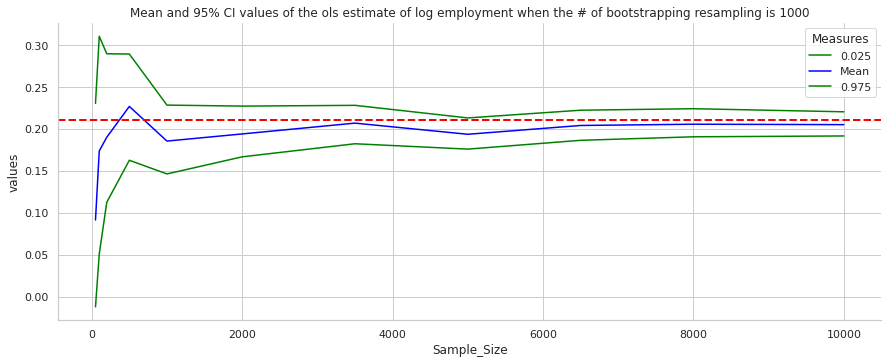

In [29]:
plot_CI_ols(df_ci_mean_log_emp, pop_val = 0.2105, title = 'ols estimate of log employment')